# Importación de las librerias y carga de archivo STL del Gomboc

In [12]:
import numpy as np
import trimesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.interpolate import griddata


In [13]:
# Cargar archivo STL
mesh = trimesh.load_mesh(r"C:\Users\David\Documents\Material Universidad\Retos\STL\Monostatic_Body_Release.STL")

# Calculo del Tensor de Inercia diagonalizado y los ejes principales de inercia

In [14]:
# Calcular el volumen, centro de masa y el tensor de inercia
volume = mesh.volume
centroid = mesh.center_mass
inertia_tensor = mesh.moment_inertia  # Si deseas considerar densidad, multiplica por la densidad

print("Volumen:", volume)
print("Centro de masa:", centroid)

# Suponiendo que 'inertia_tensor' es tu tensor de inercia 3x3:
eigvals, eigvecs = np.linalg.eigh(inertia_tensor)

print("Momentos principales de inercia:", eigvals)
print("Ejes principales (columnas de eigvecs):", eigvecs)

Volumen: 89212.22492407954
Centro de masa: [80.49488329 88.54194673 95.20570733]
Momentos principales de inercia: [24901669.53172833 29005396.24250979 30434525.59219955]
Ejes principales (columnas de eigvecs): [[ 1.00000000e+00 -1.57687699e-05 -4.48030212e-06]
 [ 1.57688190e-05  1.00000000e+00  1.09607803e-05]
 [ 4.48012928e-06 -1.09608509e-05  1.00000000e+00]]


# Grafica de los eigenvectors o vectores propios del movimiento del Gomboc

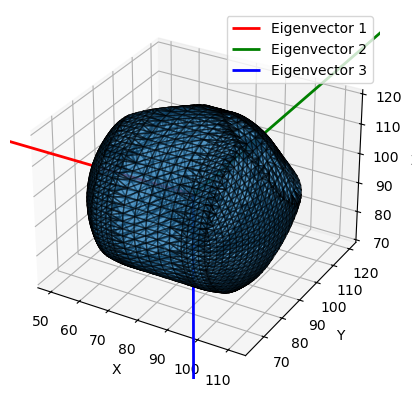

In [15]:
# Crear figura 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Graficar la malla STL
ax.add_collection3d(Poly3DCollection(mesh.vertices[mesh.faces], alpha=0.5, edgecolor="k"))

# Graficar los vectores propios en el centro de masa
colors = ['r', 'g', 'b']  # Colores para los ejes principales
scale = np.max(eigvals) ** 0.5  # Escalar los vectores para visualización

for i in range(3):  # Para cada eje principal
    ax.quiver(centroid[0], centroid[1], centroid[2], 
              eigvecs[0, i] * scale, eigvecs[1, i] * scale, eigvecs[2, i] * scale, 
              color=colors[i], linewidth=2, label=f'Eigenvector {i+1}')

# Configurar la visualización
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.auto_scale_xyz(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.vertices[:, 2])

# Mostrar leyenda y gráfico
ax.legend()
plt.show()

# Se definen los triangulos del archivo STL

In [16]:
# Obtener los vértices y caras de la malla
vertices = mesh.vertices
faces = mesh.faces

# Definicion de la posicion de los vertices de cada triangulo
V1 = vertices[faces[:, 0]]
V2 = vertices[faces[:, 1]]
V3 = vertices[faces[:, 2]]

# Calculo de los vectores normales a la superficie

In [17]:
# Producto cruzado de los lados del triángulo
normals = np.cross(V2 - V1, V3 - V1)

# Normalizar los vectores normales
normals /= np.linalg.norm(normals, axis=1, keepdims=True)

print(normals)

[[-0.32841567  0.77452338  0.5406077 ]
 [-0.42981643  0.72318684  0.5406095 ]
 [-0.4776886   0.69250267  0.54060489]
 ...
 [ 0.22626223  0.38399058 -0.89518525]
 [ 0.22626501  0.38399158 -0.89518412]
 [ 0.22626232  0.38399115 -0.89518499]]


# Calculo de los vectores desde el centro de masa a la superficie

In [18]:
midpoints = (V1 + V2 + V3) / 3  # Puntos medios de los triángulos

# Calcular los vectores desde el centro de masa a cada punto medio
vectors = midpoints - centroid

print(vectors)

[[ -9.69789385  21.89183013  12.24958442]
 [-12.12281044  20.59074879  12.24958442]
 [-13.55092374  19.64630604  12.24958442]
 ...
 [  6.35008232   8.63685576 -23.32095697]
 [  6.73496493   9.97851531 -22.64816898]
 [  7.05450941   9.97851531 -22.56740167]]


# Calculo de la altura del centro de masa

In [19]:
def altura_centro_masa(vectors, normals):
    """
    Calcula la proyección (producto punto) de cada vector sobre su correspondiente normal.
    Parámetros:
      vectors : np.ndarray de shape (N, 3)
          Vectores desde el centro de masa hasta los centros de los triángulos.
      normals : np.ndarray de shape (N, 3)
          Vectores normales (normalizados) de cada triángulo.
    Retorna:
      alturas : np.ndarray de shape (N,)
          Producto punto de cada par, que se interpretará como la "altura".
    """
    alturas = np.sum(vectors * normals, axis=1)
    return alturas

In [20]:
# Calculamos las alturas (proyecciones)
alturas = altura_centro_masa(vectors, normals)
print("Alturas (proyecciones del vector desde el centro de masa):\n", alturas)

Alturas (proyecciones del vector desde el centro de masa):
 [26.76289417 26.72378335 26.70042649 ... 25.62983181 25.62983403
 25.62983038]


# Parametrización de los vectores con respecto a theta y phi

In [21]:
def compute_theta_phi(vectors, eigvecs):
    """
    Calcula los ángulos theta y phi a partir del producto punto con los eigenvectores 2 y 1.

    Parámetros:
      vectors : np.ndarray de shape (N, 3)
          Vectores desde el centro de masa hasta los centros de los triángulos.
      eigvecs : np.ndarray de shape (3, 3)
          Matriz de eigenvectores, donde:
             - eigvecs[:, 1] es el eigenvector 2
             - eigvecs[:, 0] es el eigenvector 1
    
    Retorna:
      theta : np.ndarray de shape (N,)
          Ángulo polar calculado con respecto al eigenvector 2.
      phi   : np.ndarray de shape (N,)
          Ángulo azimutal calculado con respecto al eigenvector 1.
    """
    # Extraer y normalizar los eigenvectores 2 y 1
    e2 = eigvecs[:, 1] / np.linalg.norm(eigvecs[:, 1])  # Eigenvector 2 (z)
    e1 = eigvecs[:, 0] / np.linalg.norm(eigvecs[:, 0])  # Eigenvector 1 (x)

    # Calcular la norma de cada vector
    vector_norms = np.linalg.norm(vectors, axis=1)

    # Evitar divisiones por cero
    vector_norms[vector_norms == 0] = 1  # Para evitar problemas en la división

    # Calcular theta
    dot_product_theta = np.dot(vectors, e2)  # Producto punto con eigenvector 2
    cos_theta = dot_product_theta / vector_norms
    theta = np.arccos(np.clip(cos_theta, -1, 1))  # Clip para evitar valores fuera de dominio

    # Calcular phi
    dot_product_phi = np.dot(vectors, e1)  # Producto punto con eigenvector 1
    cos_phi = dot_product_phi / vector_norms
    phi = np.arccos(np.clip(cos_phi, -1, 1))  # Clip para evitar valores fuera de dominio

    return theta, phi

In [22]:
# Parametrización
theta, phi = compute_theta_phi(vectors, eigvecs)
print("Theta:", min(theta), max(theta))
print("Phi:", min(phi), max(phi))


Theta: 0.03205152413307087 3.078756593968003
Phi: 0.010174308026932912 3.119453496725533


# Gráfica proporcional del potencial gravitacional

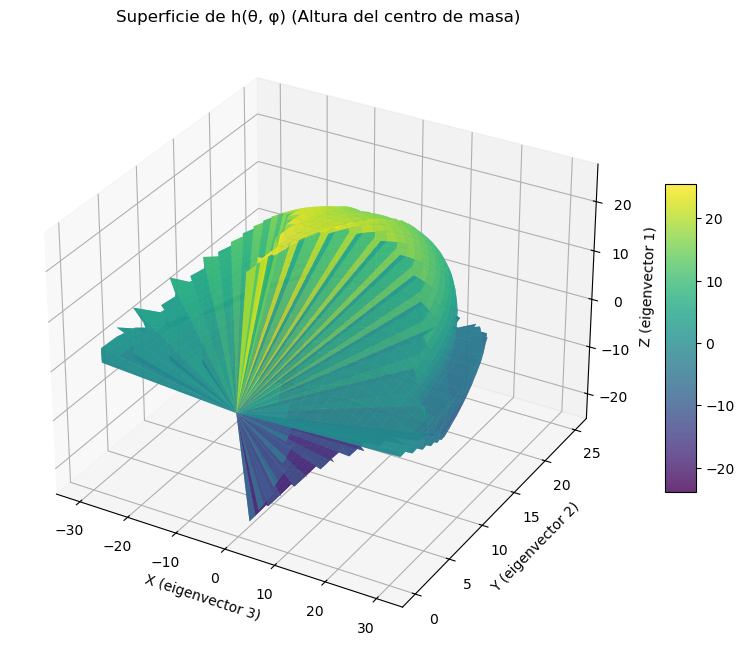

In [23]:
# --- INTERPOLACIÓN PARA GRAFICAR COMO SUPERFICIE ---
# Creamos una malla regular en theta y phi. Se asume que theta está en [0,π] y phi en [-π, π].
theta_lin = np.linspace(0, np.pi, 100)
phi_lin = np.linspace(-np.pi, np.pi, 100)
theta_grid, phi_grid = np.meshgrid(theta_lin, phi_lin)

# Interpolar los valores de alturas (dispersos) sobre la malla regular.
# Se utiliza griddata: points es (theta, phi) de cada muestra, y se interpola sobre la malla.
points = np.column_stack((theta, phi))
grid_alturas = griddata(points, alturas, (theta_grid, phi_grid), method='linear')

# Opcional: rellenamos valores nan que pueda haber en la interpolación.
grid_alturas = np.nan_to_num(grid_alturas)

# Convertir coordenadas esféricas a cartesianas usando:
#   X = r sin(theta) cos(phi)
#   Y = r sin(theta) sin(phi)
#   Z = r cos(theta)
X_grid = grid_alturas * np.sin(theta_grid) * np.cos(phi_grid)
Y_grid = grid_alturas * np.sin(theta_grid) * np.sin(phi_grid)
Z_grid = grid_alturas * np.cos(theta_grid)

# --- GRAFICAR LA SUPERFICIE ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X_grid, Y_grid, Z_grid, cmap='viridis', edgecolor='none', alpha=0.8)
ax.set_xlabel("X (eigenvector 3)")
ax.set_ylabel("Y (eigenvector 2)")
ax.set_zlabel("Z (eigenvector 1)")
ax.set_title("Superficie de h(θ, φ) (Altura del centro de masa)")
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()